# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, some template code has already been provided for you ...


<a id='step1'></a>
### Step 1: Inference Setup

In [17]:
all_modes = ['train', 'val', 'test']
assert 'traisn' in all_modes, "mode must be one of 'train', 'val', or 'test'"

AssertionError: mode must be one of 'train', 'val', or 'test'

In [1]:
from data_loader import get_loader
from torchvision import transforms

# TODO: Specify the saved models to load.
encoder_file = 'encoder-5.pkl' 
decoder_file = 'decoder-5.pkl' 

# TODO: Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# TODO: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0. 485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


test_dir = '../cocoapi/images/test2014/'
# Create the data loader.
data_loader = get_loader(transform=transform_test,                                    
                         captions_file=None)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab) 

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...


  0%|          | 0/414113 [00:00<?, ?it/s]

Done (t=0.60s)
creating index...
index created!
Obtaining caption lengths ...


100%|██████████| 414113/414113 [00:41<00:00, 10074.19it/s]


In [2]:
%load_ext autoreload
% autoreload 2

In [3]:
import os
import torch
from model import EncoderCNN, DecoderRNN

encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


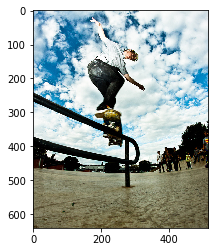

Original caption: A person doing a trick on a rail while riding a skateboard.


In [27]:
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline



ann_id = random.sample(list(coco.anns.keys()), 1)[0]
img_id = coco.anns[ann_id]['image_id']
image_path = coco.loadImgs(img_id)[0]['file_name']
caption = coco.anns[ann_id]['caption']

image = Image.open(os.path.join(val_dir, image_path)).convert('RGB')
# display image
plt.imshow(image)
plt.show()
print('Original caption:', caption)

image_tensor = transform_val(image).unsqueeze(0)

In [28]:
import torch
from torch.autograd import Variable

def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

image_var = to_var(image_tensor, volatile=True)

In [29]:
features = encoder(image_var)
output = decoder.sample(features)
output = output.cpu().data.numpy()

NameError: name 'feature' is not defined

In [30]:
sampled_ids = []
inputs = features.unsqueeze(1) # 1 x 1 x 256
states = None

for i in range(20):
    hiddens, states = decoder.lstm(inputs, states)
    outputs = decoder.linear(hiddens.squeeze(1))
    predicted = outputs.max(1)[1]
    sampled_ids.append(predicted.data[0])
    inputs = decoder.embed(predicted)
    inputs = inputs.unsqueeze(1)
#sampled_ids = torch.Tensor(sampled_ids)

print(sampled_ids)

[1, 1774, 5061, 3591, 1774, 6701, 3550, 1774, 2352, 5021, 3722, 2, 2, 3722, 2, 2, 2, 2, 2, 2]


In [31]:
' '.join([vocab.idx2word[i] for i in sampled_ids])

'<start> a man riding a skateboard down a cement ramp . <end> <end> . <end> <end> <end> <end> <end> <end>'